### Image Data Preprocessing
[Keras documentation](https://keras.io/api/preprocessing/image/)

In [80]:
import warnings

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None;

## Exploratory Data Analysis и подсчет окон и колонн в предложенном датасете

In [72]:
# загружаем метки
labels = pd.read_csv("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\labels.csv")
labels.head(19)

,filename,background,facade,window,door,cornice,sill,balcony,blind,deco,molding,pillar,shop
0,cmp_b0001.jpg,0,1,1,1,1,1,1,1,1,1,1,1
1,cmp_b0001.png,0,1,1,1,1,1,1,1,1,1,1,1
2,cmp_b0002.jpg,1,0,1,1,1,1,1,1,1,1,1,1
3,cmp_b0002.png,1,0,1,1,1,1,1,1,1,1,1,1
4,cmp_b0003.jpg,1,1,0,1,1,1,1,1,1,1,1,1
5,cmp_b0003.png,1,1,0,1,1,1,1,1,1,1,1,1
6,cmp_b0004.jpg,1,1,1,0,1,1,1,1,1,1,1,1
7,cmp_b0004.png,1,1,1,0,1,1,1,1,1,1,1,1
8,cmp_b0005.jpg,1,1,1,1,0,1,1,1,1,1,1,1
9,cmp_b0005.png,1,1,1,1,0,1,1,1,1,1,1,1


In [49]:
labels.shape

(756, 13)

In [59]:
labels[['window', 'pillar', 'facade']].describe().T

,count,mean,std,min,25%,50%,75%,max
window,756.0,0.640212,0.480256,0.0,0.0,1.0,1.0,1.0
pillar,756.0,0.965608,0.182353,0.0,1.0,1.0,1.0,1.0
facade,756.0,0.589947,0.492169,0.0,0.0,1.0,1.0,1.0


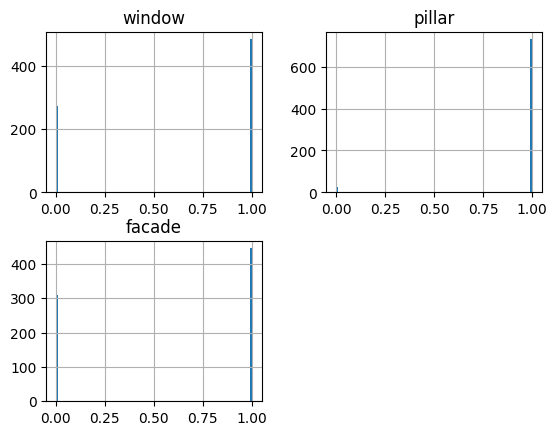

In [60]:
labels[['window', 'pillar', 'facade']].hist(bins=100);

Общая информация о данных и типах переменных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    756 non-null    object
 1   background  756 non-null    int64 
 2   facade      756 non-null    int64 
 3   window      756 non-null    int64 
 4   door        756 non-null    int64 
 5   cornice     756 non-null    int64 
 6   sill        756 non-null    int64 
 7   balcony     756 non-null    int64 
 8   blind       756 non-null    int64 
 9   deco        756 non-null    int64 
 10  molding     756 non-null    int64 
 11  pillar      756 non-null    int64 
 12  shop        756 non-null    int64 
dtypes: int64(12), object(1)
memory usage: 76.9+ KB
None
Описательные статистики для данных
       background      facade      window        door     cornice        sill  \
count  756.000000  756.000000  756.000000  756.000000  756.000000  756.00000

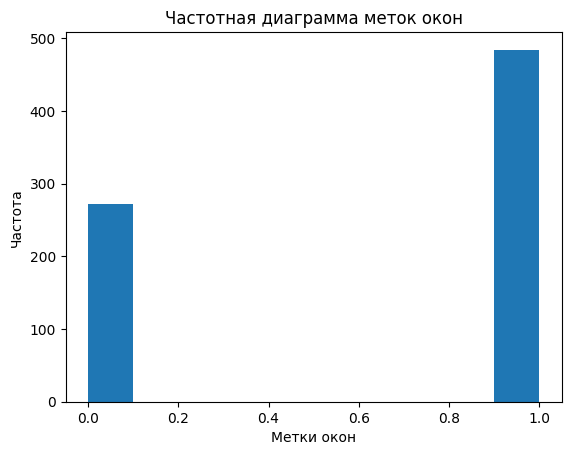

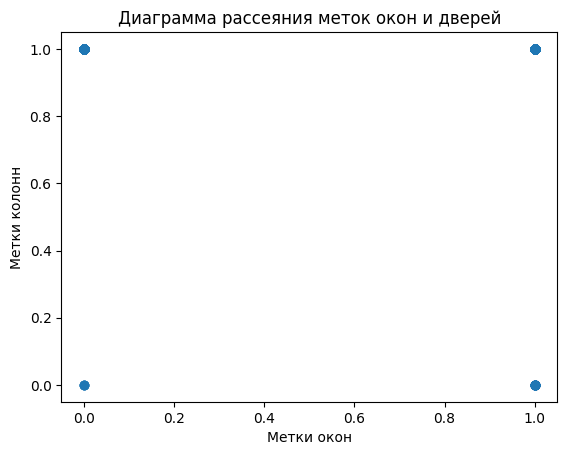

C:\Users\HOME\AppData\Local\Temp\ipykernel_16896\24115376.py:29: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(labels.corr(), annot=True)


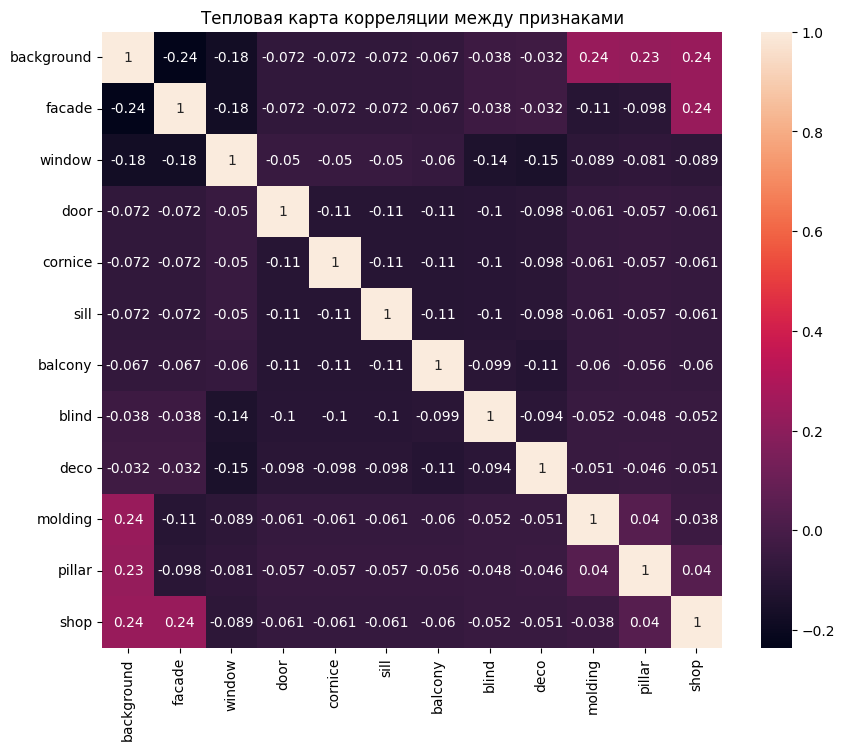

In [62]:
# Display information about the data types and number of non-null values in each column
print("Общая информация о данных и типах переменных:")
print(labels.info())

# Display basic statistical information about each column
print("Описательные статистики для данных")
print(labels.describe())

# Count the number of occurrences of each value in the 'facade' column
print("Количество значений в столбце 'фасад'")
print(labels['facade'].value_counts())

# Create a histogram of the values in the 'window' column
plt.hist(labels['window'])
plt.title('Частотная диаграмма меток окон')
plt.xlabel('Метки окон')
plt.ylabel('Частота')
plt.show()

# Create a scatter plot of the 'window' and 'door' columns
plt.scatter(x=labels['window'], y=labels['pillar'])
plt.title('Диаграмма рассеяния меток окон и дверей')
plt.xlabel('Метки окон')
plt.ylabel('Метки колонн')
plt.show()

# Create a heatmap of the correlations between columns
plt.figure(figsize=(10,8))  # set the figure size to 10 x 8 inches
sns.heatmap(labels.corr(), annot=True)
plt.title('Тепловая карта корреляции между признаками')
plt.show()

### *Выводы:* Видим, что данные закодированы бинарно, всего 11 признаков и 756 картинок в датасете. Проверка на мультиколлеарность показала, что высоко коррелирующих признаков нет, что является хорошим знаком для дальнейшего обучения модели.

Посмотрим, как выглядят картинки в разных форматах - png, xml, jpg.

In [64]:
# pip install -qq lxml

In [65]:
# import xml.etree.ElementTree as ET # to open xml file
# xml_file = "C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base\\cmp_b0076.xml"
#
# try:
#     # Parse the XML file
#     tree = ET.parse(xml_file)
#     root = tree.getroot()
#
#     # Extract the values of the desired elements
#     building = root.find('building')
#     print("Building ID:", building.attrib['id'])
#
#     facade = building.find('facade')
#     print("Facade ID:", facade.attrib['id'])
#
#     for window in facade.findall('window'):
#         print("Window ID:", window.attrib['id'])
#         print("Window position:", window.attrib['pos'])
#         print("Window size:", window.attrib['size'])
#
# except ValueError as e:
#     print("XML Syntax Error:", e)

The XMLSyntaxError: Extra content at the end of the document error occurs when there is extra content after the end of the XML document, as indicated by the line and column numbers in the error message.

To fix this error, you need to remove the extra content from the XML file. This extra content could be anything that comes after the closing </cmp_root> tag, such as whitespace, comments, or other data.

Here is an example of what the end of a well-formed XML file should look like:
```
</cmp_root>
```

In [66]:
# png
cv2.imread("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base\\cmp_b0242.png")

array([[[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [170,   0,   0],
        [170,   0,   0],
        [170,   0,   0]],

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [170,   0,   0],
        [170,   0,   0],
        [170,   0,   0]],

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [170,   0,   0],
        [170,   0,   0],
        [170,   0,   0]],

       ...,

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [170,   0,   0],
        [170,   0,   0],
        [170,   0,   0]],

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [170,   0,   0],
        [170,   0,   0],
        [170,   0,   0]],

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [170,   0,   0],
        [170,   0,   0],
        [170,   0,   0]]

In [75]:
# jpg
cv2.imread("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base\\cmp_b0374.jpg")

array([[[229, 229, 229],
        [229, 229, 229],
        [229, 229, 229],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [229, 229, 229]],

       [[229, 229, 229],
        [229, 229, 229],
        [229, 229, 229],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [229, 229, 229]],

       [[229, 229, 229],
        [229, 229, 229],
        [229, 229, 229],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [229, 229, 229]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  2,   3,   1],
        ...,
        [  4,   0,   0],
        [  8,   3,   4],
        [  4,   0,   0]],

       [[  0,   0,   0],
        [  0,   1,   1],
        [  2,   3,   1],
        ...,
        [  4,   0,   0],
        [  8,   3,   4],
        [  4,   0,   0]],

       [[  0,   1,   1],
        [  0,   2,   2],
        [  1,   2,   0],
        ...,
        [  4,   0,   0],
        [  8,   3,   4],
        [  4,   0,   0]]

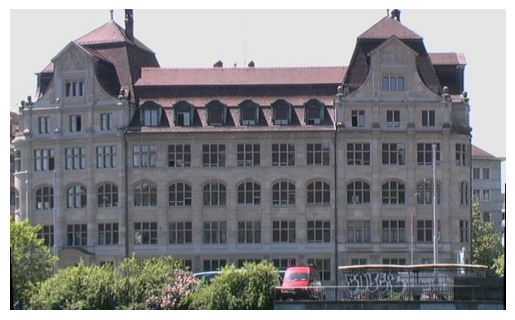

In [78]:
img = cv2.imread("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base\\cmp_b0374.jpg")

# Convert the image from BGR to RGB format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

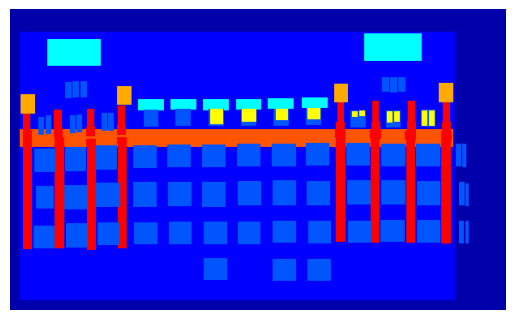

In [79]:
img1 = cv2.imread("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base\\cmp_b0374.png")

# Convert the image from BGR to RGB format
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img1)
plt.axis('off')
plt.show()

In [93]:
try:
    # Filter the dataframe to include only rows corresponding to the cmp_b0374 image
    img_labels = labels.loc[labels['filename'] == 'cmp_b0374.jpg']

    # Extract the filename and file extension from the relevant columns
    filename = img_labels['filename'].iloc[0]  # get the filename from the 'filename' column
    file_extension = os.path.splitext(img_labels['filename'].iloc[0])[1]  # get the file extension from the 'filename' column

    # Print the filename and file extension
    print("Filename:", filename)
    print("File extension:", file_extension)

except IndexError:
    print("IndexError: Index out of range. Check that there are at least 2 rows with filename 'cmp_b0374'.")

Filename: cmp_b0374.jpg
File extension: .jpg


In [94]:
# отфильтруем картинку cmp_b0374
try:
    # Filter the dataframe to include only rows corresponding to the cmp_b0374 image
    img_labels = labels.loc[labels['filename'] == 'cmp_b0374.png']

    # Extract the filename and file extension from the relevant columns
    filename = img_labels['filename'].iloc[0]  # get the filename from the 'filename' column
    file_extension = os.path.splitext(img_labels['filename'].iloc[0])[1]  # get the file extension from the 'filename' column

    # Print the filename and file extension
    print("Filename:", filename)
    print("File extension:", file_extension)

except IndexError:
    print("IndexError: Index out of range. Check that there are at least 2 rows with filename 'cmp_b0374'.")

Filename: cmp_b0374.png
File extension: .png


In [ ]:
# Split the image into its RGB channels
blue_channel, green_channel, red_channel = cv2.split(img)

# cv2.imshow("Blue channel", blue_channel)
# cv2.imshow("Green channel", green_channel)
# cv2.imshow("Red channel", red_channel)
# cv2.waitKey(0)

### Видим, что в датасете у нас png-картинки обработаны, а jpg-картинки - их исходные фотографии. Чтобы не дублировать данные, для подсчета колонн и окон будем использовать только png-картинки с тремя выделенными каналами.

Каждый цвет на обработанных картинках — это отдельный класс: окно, колонна.

Перед нами стоит задача сегментации фасада, которая делится на подзадачи. Нам нужно присвоить каждому пикселю определённый класс, то перед нами задача семантической сегментации (англ. semantic segmentation). На выходе модель семантической сегментации должна вернуть маску — изображение, в котором объекты одного класса должны иметь один и тот же цвет. При этом, если на фото присутствуют два или три окна, то они будут иметь один класс (цвет).

#### Подсчитаем количество окон и колонн в данных.
*Допущение:* В рамках данного проекта допускаем, что все картинки выбранного датасета - это дома в одном районе.

In [ ]:
# total number of windows
total_windows = labels['window'].sum()
print("Общее количество окон:", total_windows)

# total number of pillars
total_pillars = labels['pillar'].sum()
print("Общее количество колонн:", total_pillars)

Первая часть задачи заказчика решена, переходим к сегментации фасадов зданий.